## Tutorial 3: Segmenting Radar Images 
---

*Authors: [Joe Fennell](https://github.com/joe-fennell/), [Therese Cantwell](https://github.com/TMCantwell/), [Andrés Aguilar Ariza](https://github.com/anaguilarar/) & [Anna Scaife](https://github.com/as595/).*

---

<div class="alert alert-block alert-info">
<b>Objective:</b> You will use data from the Sentinel-1 satellite to identify flooded regions in Puerto Rico following Hurricane Maria.
</div>


On the 18th of September 2017 [Hurricane Maria](https://en.wikipedia.org/wiki/Hurricane_Maria) made landfall in Puerto Rico. Torrential rain and high winds caused extensive damage to infrastructure and led to widespread flooding. 

In this tutorial we will use radar data provided by the European Space Agency [Sentinel 1 Mission](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/sentinel-1) to identify flooded regions. We will do this using image segmentation and k-means clustering. 

The data for this tutorial is in the form of 3 pre-processed images, the first taken before the hurricane on 16/09/17, the second taken  just after the hurricane on 22/09/17 and the last taken one month after the hurricane on 22/10/17. 


---

### Loading the data:

We'll start by importing the numpy, matplotlib and scikit-learn libraries that we used in tutorials 1 and 2:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import cluster, preprocessing

and for this tutorial we're also going to use the [scikit-image](https://scikit-image.org),  [pandas](https://pandas.pydata.org) and [scipy]() libraries, as well as the [global](https://docs.python.org/2/library/glob.html) module that is included with your python distribution (i.e. it doesn't need to be separately installed):

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import pandas as pd
import scipy as sp
import glob

---

### Preparing the data:

The instrument onboard the Sentinel-1 satellites transmits in one polarisation (V) and measures in two (V and H), giving the VV and VH bands. The first band in each data file is the signal measured in the same polarisation as the transmission (VV) and the second is measured in the orthogonal polarisation (VH).

First let's define a function <code>load_data</code> to read data from the input numpy arrays:

In [ ]:
def load_data(filename):
    
    im=np.load(filename)
    
    return im

Then we define a second function to calculate the *surface polarisation* and add this to our dataset as a third axis. The *surface polarisation* is the ratio of polarisation in the first two bands. 

In [ ]:
def data_preprocess(data_array):
    
    processed_data=np.zeros(np.shape(data_array))
    
    processed_data[:,:,0]=data_array[:,:,0]
    processed_data[:,:,1]=data_array[:,:,1]
    processed_data[:,:,2]=data_array[:,:,0]/data_array[:,:,1]
    
    return processed_data

Because we're loading multiple datasets, we can use the [glob]() library to get a list of all the datasets with the correct naming convention from our input data directory. This way we don't need to hardcode the names separately:

In [ ]:
radar_data=glob.glob('data/SAR*npy')
print(radar_data)

We need to sort this list to get the input data files into the correct date order:

In [ ]:
radar_data.sort()
print(radar_data)

Now let's load each dataset from the list:

In [ ]:
day1=load_data(radar_data[0])
day2=load_data(radar_data[1])
day3=load_data(radar_data[2])

In [ ]:
day1[0][0], day_1_preprocessed[0][0]

We can then apply our preprocessing (i.e. add in the surface polarization):

In [ ]:
day_1_preprocessed=data_preprocess(day1)
day_2_preprocessed=data_preprocess(day2)
day_3_preprocessed=data_preprocess(day3)

In [ ]:
day_1_preprocessed.shape

---

### Visualise the data:

Let's see what it looks like. We're going to plot a sub-region of the image for the pixel ranges: [0:1000, 2000:3000]

In [ ]:
f = plt.figure(figsize=(12,12))

f.add_subplot(131)
plt.imshow(day_1_preprocessed[0:1000,2000:3000,0],'viridis')
plt.title('day1 - zoom - vv')

f.add_subplot(132)
plt.imshow(day_1_preprocessed[0:1000,2000:3000,1],'viridis')
plt.title('day1 - zoom - vh')

f.add_subplot(133)
plt.imshow(day_1_preprocessed[0:1000,2000:3000,2],'viridis')
plt.title('day1 - zoom  - sp ')
plt.show()

Let's define this sub-region as our input *training data*:

In [ ]:
day1_training=day_1_preprocessed[0:1000,2000:3000,:]

We can then define another region - here I've chosen [400:1400, 3300:4300] - as our *test* data. 

In [ ]:
day1_test=day_1_preprocessed[400:1400,3300:4300,:]
day2_test=day_2_preprocessed[400:1400,3300:4300,:]
day3_test=day_3_preprocessed[400:1400,3300:4300,:]

---

### Segment the data:

Now we'll use the [segmentation module](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic) from [scikit-image](http://scikit-image.org/docs/dev/api/skimage.segmentation.html) to create image segments. 
Each of these segments will be treated as a **superpixel**. We will calculate statistics for each of the superpixels and use these as the input features for the K-means algorithm. 

The function <code>calculate_segment_stats</code> will calculate:

* the minimum value, 
* the maximum value, 
* the mean, 
* the variance, 
* the skewness, and 
* the kurtosis 

for each superpixel in each channel.

In [ ]:
number_segments=50000
segments = slic(day1_training, n_segments=number_segments, compactness=50, sigma = 0, convert2lab=False)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(mark_boundaries(day1_training[:,:,0]/255, segments))
plt.show()

In [ ]:
def calculate_segment_stats(data, segments):
    
    # turn the image into a 2D array (pix by channel)
    d1_flat = pd.DataFrame(np.ravel(data).reshape((-1,3)))

    # add the label vector
    d1_flat['spID'] = np.ravel(segments)

    
    print(d1_flat)
    
    # calculate the mean by segment
    return d1_flat.groupby('spID').mean().values

In [ ]:
seg_means = calculate_segment_stats(day1_training,segments)
plt.figure(figsize=(20,20))
# broadcast the mean pixel values from the first channel
# to the same shape as the original image array
plt.imshow(seg_means[:,0][segments])

In [ ]:
seg_means.shape

---

### Clustering the data:

Now we will apply k-means clustering to the training data feature set that we've created using the steps above. We will search for three clusters in the data. 

We can then apply the segment classification to every pixel in the superpixel. 

In [ ]:
kmeans_3clusters=cluster.KMeans(n_clusters=3)
kmeans_3clusters.fit(seg_means)

Now let's display the area colour-coded by cluster, and I'm also going to add a rectangle over part of the image:

In [ ]:
# this is the bit that displays the figure:
plt.figure(figsize=(10,10))
plt.imshow(kmeans_3clusters.labels_[segments],'viridis')
plt.colorbar()

# this is the bit that adds the rectangle:
rect = mpl.patches.Rectangle((750,50),200,200,linewidth=5,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)

You can see from the figure above that I've put the rectangle over an area of the image which I'm pretty certain is water.

---

### Using the data to monitor flooding:

From the above image we have some prior intuition that the area in the red square is ocean and so we can assume that the most common class in this region is going to represent water. We want to know what cluster that corresponds to in the k-means clustering.

If we check the cluster labels for the pixels in that region the most common value (i.e. the *mode*) should be the cluster corresponding to water. I'm going to use the [scipy stats library mode function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html).

In [ ]:
training = kmeans_3clusters.labels_[segments][50:250,750:950]
water_label = int(sp.stats.mode(training, axis=None).mode)
print('The water label is: ',water_label)

We are interested in applying this approach to a larger area, so we need a function to predict the label for new data. To do this, we simply wrap the model and slic algorithm into a function for convenience:

In [ ]:
def predict(data, model, number_segments=number_segments):
    
    """ 
    Function to return labelled image
    """
    
    # segment the image
    test_segments = slic(data,
                         n_segments=number_segments,
                         compactness=50,
                         sigma = 0,
                         convert2lab=False)
    
    # calculate seg stats 
    test_set = calculate_segment_stats(data,test_segments)
    
    # predict
    test_set_segment_labels=model.predict(test_set)
    
    # code via broadcasting
    return test_set_segment_labels[test_segments]

We can then apply this to new areas:

In [ ]:
day1_labels=predict(day1_test,kmeans_3clusters)
day2_labels=predict(day2_test,kmeans_3clusters)
day3_labels=predict(day3_test,kmeans_3clusters)

Let's display the results to see how it looks:

In [ ]:
f = plt.figure(figsize=(12,12))

f.add_subplot(131)
plt.imshow(day1_labels)
plt.title("Day 1")

f.add_subplot(132)
plt.imshow(day2_labels)
plt.title("Day 2")

f.add_subplot(133)
plt.imshow(day3_labels)
plt.title("Day 3")
plt.show()

Using the water cluster label to produce boolean arrays of 'water' at 2 time points and the NumPy logic functions, we can identify areas of water that were not present before the hurricane and were present afterwards.

In [ ]:
day1_water = day1_labels==water_label
day2_water = day2_labels==water_label

We can then display the difference using the [logical exclusive ('XOR')](https://en.wikipedia.org/wiki/Exclusive_or) function:

In [ ]:
flooding = np.logical_xor(day1_water,day2_water)
plt.figure(figsize=(10,10))
plt.imshow(flooding, 'binary_r')
plt.title('Flooded areas on 22/09/2017')
plt.show()

---

End of Tutorial 3! Well done on completing the tutorials. You may now proceed to the hackathon task!

## Hackathon Task



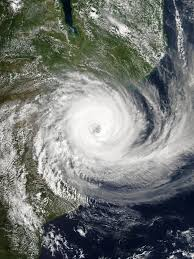



On March 13th of 2019, Cyclone Idia made landfall in Mozambique and was one of the worst recorded tropical cyclones to affect Africa and the Southern-Hemisphere. Within the _task data_ folder, you will find satellite imagery data from the Sentinel satellite for an area over Mozambique affected by flooding. The data comprises of six images spanning a time frame from the 13th to the 26th of March. Your task is to perform a flood detection analysis using this dataset.

When performing the analysis, attempt to answer the following questions:

- What part of the image did you choose to use as your training set and why? Show a plot of your training set.
- What part of the image did you choose to use as your test set and why?
- How many segments did you choose to use during the image segmentation process?
- How many clusters did you choose to use when applying the k-means clustering technique?


Try to produce the following plots:

- Show plots of the images (the whole image or the same portion thereof) over the six days after the clustering method has been applied.
- Show plots of the progression of the flooded regions over the six days? That is, show the difference in water coverage from one day to the next.


Some additional questions:

- Does the amount of vegetation cover affect the severity of the flooding?
- What is the affect of not having data for some of the days in between those provided? Can you estimate the amount of flooding for days on which you do not have data?


An additional challenge:

Can you calculate the area/percentage of the image that is covered by water? How does this change over the six days?

## All the best!!